In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param
from numba import jit
from matplotlib import ticker

In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

In [4]:
from iminuit import Minuit
from iminuit import util
from iminuit.cost import LeastSquares

In [23]:
def line(x, α, β):
    return α + x * β


rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

In [24]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)

m.limits = [(0, 2), (0, 3)]

# m.errordef = Minuit.LIKELIHOOD

m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 109              │
│ EDM = 1.21e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.02    │   0.06    │            │            │    0    │    2    │       │
│ 1 │ β    │    2.0    │    0.1    │            │            │    0    │    3    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

In [5]:
t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_plus250kA_nominal_sk.csv"
)

t2kflux_2020_minus250kA_nominal_sk = conv.fluximport(
    "t2kflux_2020_minus250kA_nominal_sk.csv"
)

neutrino_ccqe = conv.xsecimport(
    name="neutrino_ccqe.csv",
    mode="true filter interp",
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

antineutrino_ccqe = conv.xsecimport(
    name="antineutrino_ccqe.csv",
    mode="true filter interp",
    on=(t2kflux_2020_plus250kA_nominal_sk.minE + t2kflux_2020_plus250kA_nominal_sk.maxE)
    / 2,
)

ccqe_energy_res_interp = conv.energyimport(
    name="ccqe_energy_res.csv", mode="interp", on=np.linspace(-0.5, 1.0, 125)
)

number_fhc = pd.DataFrame()
for key in ["minE", "maxE"]:
    number_fhc[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "nue"]:
    number_fhc[key] = (
        (neutrino_ccqe.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["FHC"]
        * param.TOT_NEUTRONS
        * 2
    )
for key in ["antinumu", "antinue"]:
    number_fhc[key] = (
        (antineutrino_ccqe.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["RHC"]
        * param.TOT_NEUTRONS
        * 2
    )
number_fhc["nutau"] = 0.0
number_fhc["antinutau"] = 0.0

number_rhc = pd.DataFrame()
for key in ["minE", "maxE"]:
    number_rhc[key] = t2kflux_2020_minus250kA_nominal_sk[key]
for key in ["numu", "nue"]:
    number_rhc[key] = (
        (neutrino_ccqe.xsec * t2kflux_2020_minus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["FHC"]
        * param.TOT_NEUTRONS
        * 2
    )
for key in ["antinumu", "antinue"]:
    number_rhc[key] = (
        (antineutrino_ccqe.xsec * t2kflux_2020_minus250kA_nominal_sk[key] / (50 * 1e21))
        * param.SK_POT["RHC"]
        * param.TOT_NEUTRONS
        * 2
    )
number_rhc["nutau"] = 0.0
number_rhc["antinutau"] = 0.0

"""
number_hk = pd.DataFrame()
for key in ["minE", "maxE"]:
    number_hk[key] = t2kflux_2020_plus250kA_nominal_sk[key]
for key in ["numu", "antinumu", "nue", "antinue"]:
    number_hk[key] = (
        (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
        * 1
        / 2
        * 2.7e22
        * param.TOT_NEUTRONS
        * 8.4
        * 2
    )
number_hk["nutau"] = 0.0
number_hk["antinutau"] = 0.0
"""
"""
def hk_hist(
    θ23=np.arcsin(np.sqrt(0.512)),
    δCP=-2.14,
    Δ2m32=2.46e-3,
):
    return conv.convolve(
        conv.oscillate(
            to_oscillate=number_hk, theta_23=θ23, delta_cp=δCP, dm2_atm=Δ2m32
        ),
        gate=ccqe_energy_res_interp,
    )
"""


def t2k_hist(number, sin2_θ23=0.528, δCP=-1.601, Δ2m32=2.509e-3):
    return conv.convolve(
        conv.oscillate(
            to_oscillate=number,
            theta_23=np.arcsin(np.sqrt(sin2_θ23)),
            delta_cp=δCP,
            dm2_atm=Δ2m32,
            theta_12=np.arcsin(np.sqrt(0.304)),
            theta_13=np.arcsin(np.sqrt(0.0212)),
            dm2_21=7.53e-5
        ),
        gate=ccqe_energy_res_interp,
    )

In [16]:
t2k_fhc = t2k_hist(number_fhc) 
((t2k_fhc.antinumu + t2k_fhc.numu) * (t2k_fhc.maxE - t2k_fhc.minE) * 1e3).loc[t2k_fhc.minE < 0.16].sum()

0.5346793376602181

In [168]:
"""
def hk_likelihood(θ23, δCP, Δ2m32):
    sk_hist_obs = hk_hist(θ23=θ23, δCP=δCP, Δ2m32=Δ2m32)
    sk_hist_exp = hk_hist()
    N_obs = sk_hist_obs["numu"] * (sk_hist_obs.maxE - sk_hist_obs.minE) * 1e3
    N_exp = sk_hist_exp["numu"] * (sk_hist_exp.maxE - sk_hist_exp.minE) * 1e3
    l = (N_exp - N_obs + N_obs * np.log(N_obs / N_exp)).sum()
    return l
"""


def t2k_likelihood(sin2_θ23, δCP, Δ2m32):
    l = 0
    for number in [number_fhc, number_rhc]:
        t2k_hist_obs = t2k_hist(number=number, sin2_θ23=sin2_θ23, δCP=δCP, Δ2m32=Δ2m32)
        t2k_hist_exp = t2k_hist(number=number)
        for key in ["numu", "nue"]:
            N_obs = (
                (t2k_hist_obs[key] + t2k_hist_obs["anti" + key])
                * (t2k_hist_obs.maxE - t2k_hist_obs.minE)
                * 1e3
            )
            N_exp = (
                (t2k_hist_exp[key] + t2k_hist_obs["anti" + key])
                * (t2k_hist_exp.maxE - t2k_hist_exp.minE)
                * 1e3
            )
            l += (N_exp - N_obs + N_obs * np.log(N_obs / N_exp)).sum()
    return l

In [11]:
t2k_likelihood(
    sin2_θ23=np.sin(param.NUFIT["theta_23"]["bf"]) ** 2,
    δCP=param.NUFIT["delta_CP"]["bf"],
    Δ2m32=param.NUFIT["Dm_square_32"]["bf"],
)

2.0457591580890173

In [24]:
some_bin = np.linspace(0e-3, 3e-2, 100)

In [20]:
rc("figure", figsize=(10, 6))
rc("font", size=20, family="Manjari")
rc("axes", labelsize=15, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=15, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=15, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=15, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)

In [ ]:
l_scan = [
    t2k_likelihood(
        sin2_θ23=np.sin(param.NUFIT["theta_23"]["bf"]) ** 2,
        δCP=param.NUFIT["delta_CP"]["bf"],
        Δ2m32=x,
    )
    for x in some_bin
]

plt.plot(
    some_bin,
    l_scan,
)

plt.axvline(x=2.51e-3, linestyle="--", color="black")
ax = plt.gca()
plt.text(
    x=2.51e-3,
    y=0.5,
    s=r"best-fit",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$\Delta m_{32}^2$ [eV$^2$]")
plt.ylabel(r"$-\ln \mathcal{L}$")
# plt.ylim(bottom=1e-1)
plt.title(r"Scan de la fonction de vraisemblance")
plt.legend()

plt.show()

In [183]:
t2k_likelihood.errordef = Minuit.LIKELIHOOD
# hk_likelihood.errordef = Minuit.LIKELIHOOD

In [185]:
m_t2k = Minuit(
    t2k_likelihood,
    sin2_θ23=0.2,  
    δCP=0,
    Δ2m32=2e-3,
)

"""
m_hk = Minuit(
    hk_likelihood,
    θ23=np.arcsin(np.sqrt(0.512)),  # T2K 2021 bf
    δCP=-2.14,
    Δ2m32=1e-3,
)
"""

'\nm_hk = Minuit(\n    hk_likelihood,\n    θ23=np.arcsin(np.sqrt(0.512)),  # T2K 2021 bf\n    δCP=-2.14,\n    Δ2m32=1e-3,\n)\n'

In [171]:
m_t2k.fixed["Δ2m32"] = True
m_t2k.fixed["sin2_θ23"] = True

"""
m_hk.fixed["θ23"] = True
m_hk.fixed["δCP"] = True
"""

'\nm_hk.fixed["θ23"] = True\nm_hk.fixed["δCP"] = True\n'

In [186]:
m_t2k.limits = [(0, 1), (-np.pi, np.pi), (0, 5e-3)]
# m_hk.limits = [(0, 2 * np.pi), (-np.pi, np.pi), (0, 5e-3)]

In [173]:
# m.errors = 1e-6

In [187]:
m_t2k.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,sin2_θ23,0.200,0.002,,,0,1,
1,δCP,0.0,0.1,,,-3.14,3.14,
2,Δ2m32,2.00e-3,0.02e-3,,,0,0.005,


In [175]:
# m_hk.params

In [ ]:
m_t2k.migrad().hesse().minos(cl=1)

In [ ]:
m_t2k.draw_mnmatrix()

In [177]:
m_t2k.values['δCP']

-2.139009751287678

In [178]:
m_t2k.errors['δCP']

1.2412090952583965

In [179]:
#m_hk.migrad()
#m_hk.hesse()

In [180]:
#m_t2k.minos(cl=3)
m_t2k.merrors.get('δCP').lower, m_t2k.merrors.get('δCP').upper

(-0.9225232556473028, 1.7013552084276637)

(array([-7.10384613, -6.90119975, -6.69855337, -6.49590698, -6.2932606 ,
        -6.09061422, -5.88796783, -5.68532145, -5.48267507, -5.28002869,
        -5.0773823 , -4.87473592, -4.67208954, -4.46944315, -4.26679677,
        -4.06415039, -3.86150401, -3.65885762, -3.45621124, -3.25356486,
        -3.05091847, -2.84827209, -2.64562571, -2.44297933, -2.24033294,
        -2.03768656, -1.83504018, -1.63239379, -1.42974741, -1.22710103,
        -1.02445465, -0.82180826, -0.61916188, -0.4165155 , -0.21386911,
        -0.01122273,  0.19142365,  0.39407003,  0.59671642,  0.7993628 ,
         1.00200918,  1.20465557,  1.40730195,  1.60994833,  1.81259472,
         2.0152411 ,  2.21788748,  2.42053386,  2.62318025,  2.82582663]),
 array([2.19275383e-01, 3.40099920e-01, 5.20329272e-01, 7.69155392e-01,
        1.08750013e+00, 1.46584234e+00, 1.88355822e+00, 2.31015214e+00,
        2.70845288e+00, 3.03943709e+00, 3.26791695e+00, 3.36803493e+00,
        3.32746132e+00, 3.14942743e+00, 2.85218996e+

/local/home/pb278543/Github/energy-effects-T2K/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 948 (\N{GREEK SMALL LETTER DELTA}) missing from font(s) Manjari.
  func(*args, **kwargs)
/local/home/pb278543/Github/energy-effects-T2K/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 948 (\N{GREEK SMALL LETTER DELTA}) missing from font(s) Manjari.
  fig.canvas.print_figure(bytes_io, **kw)


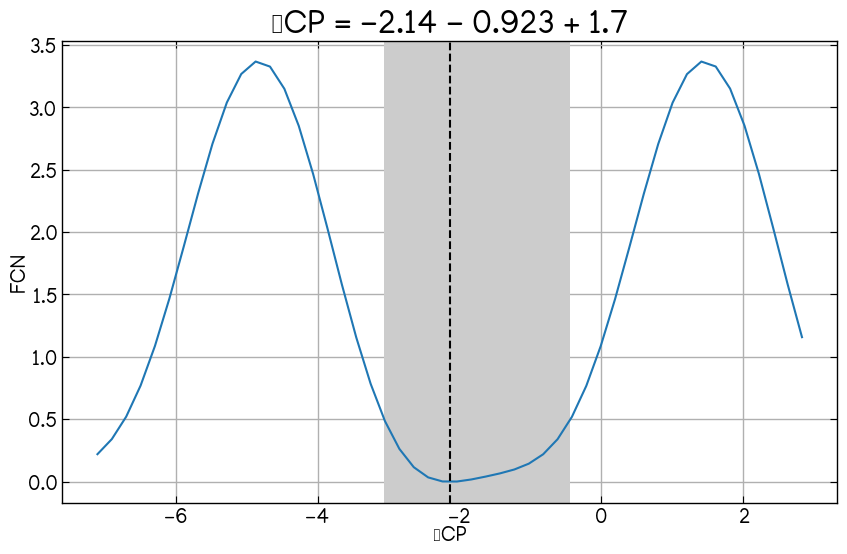

In [182]:
m_t2k.draw_mnprofile("δCP", bound=4, size=50, subtract_min=True)

In [ ]:
m_hk.minos(cl=1)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.956e-08                  │              Nfcn = 33               │
│ EDM = 1.96e-08 (Goal: 0.0001)    │           time = 70.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ θ23   │   0.797   │   0.008   │            │            │    0    │ 6.28319 │  yes  │
│ 1 │ δCP   │  -2.140   │   0.021   │            │            │-3.14159 │ 3.14159 │  yes  │
│ 2 │ Δ2m32 │ 2.460e-3  │ 0.005e-3  │ -0.005e-3  │  0.005e-3  │    0    │  0.005  │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │         Δ2m32         │
├──────────┼───────────┬───────────┤
│  Error   │   -5e-6   │   5e-6    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌───────┬────────────────────────────┐
│       │      θ23      δCP    Δ2m32 │
├───────┼────────────────────────────┤
│   θ23 │        0        0        0 │
│   δCP │        0        0        0 │
│ Δ2m32 │        0        0 2.95e-11 │
└───────┴────────────────────────────┘

In [23]:
m_sk.minos(cl=3)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.662e-08                  │              Nfcn = 42               │
│ EDM = 1.66e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sin2_θ23 │   0.512   │   0.005   │            │            │    0    │    1    │  yes  │
│ 1 │ δCP      │  -2.140   │   0.021   │            │            │-3.14159 │ 3.14159 │  yes  │
│ 2 │ Δ2m32    │  2.46e-3  │  0.05e-3  │  -0.14e-3  │  0.14e-3   │    0    │  0.005  │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │         Δ2m32         │
├──────────┼───────────┬───────────┤
│  Error   │ -0.14e-3  │  0.14e-3  │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌──────────┬────────────────────────────┐
│          │ sin2_θ23      δCP    Δ2m32 │
├──────────┼────────────────────────────┤
│ sin2_θ23 │        0        0        0 │
│      δCP │        0        0        0 │
│    Δ2m32 │        0        0 2.24e-09 │
└──────────┴────────────────────────────┘

In [19]:
m_hk.minos(cl=3)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.956e-08                  │              Nfcn = 39               │
│ EDM = 1.96e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ θ23   │   0.797   │   0.008   │            │            │    0    │ 6.28319 │  yes  │
│ 1 │ δCP   │  -2.140   │   0.021   │            │            │-3.14159 │ 3.14159 │  yes  │
│ 2 │ Δ2m32 │ 2.460e-3  │ 0.005e-3  │ -0.016e-3  │  0.016e-3  │    0    │  0.005  │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │         Δ2m32         │
├──────────┼───────────┬───────────┤
│  Error   │ -0.016e-3 │ 0.016e-3  │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌───────┬────────────────────────────┐
│       │      θ23      δCP    Δ2m32 │
├───────┼────────────────────────────┤
│   θ23 │        0        0        0 │
│   δCP │        0        0        0 │
│ Δ2m32 │        0        0 2.95e-11 │
└───────┴────────────────────────────┘

In [ ]:
m.values["Δ2m32"]

In [20]:
a_sk, fa_sk, ok_sk = m_sk.mnprofile("Δ2m32", bound=4, size=50, subtract_min=True)
a_hk, fa_hk, ok_hk = m_hk.mnprofile("Δ2m32", bound=4, size=50, subtract_min=True)

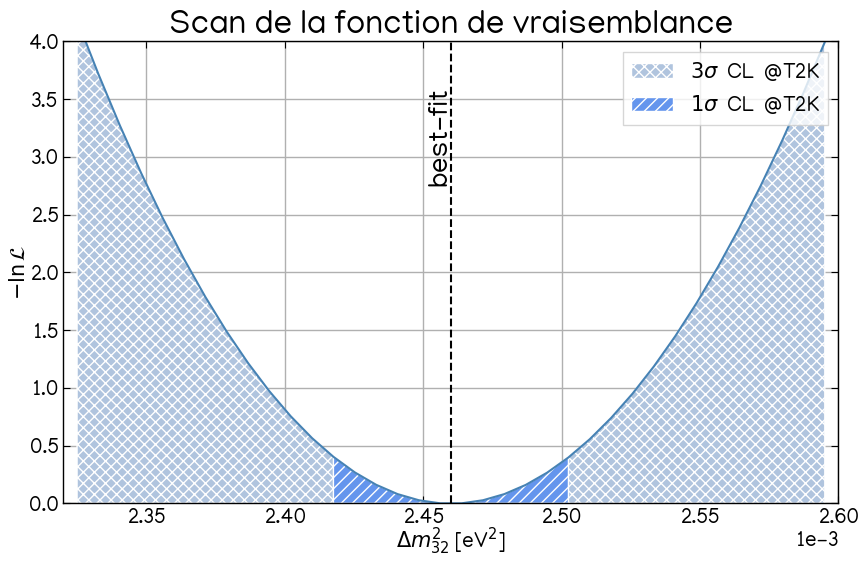

In [25]:
# plt.plot(a_hk, fa_hk, c="green")
plt.plot(a_sk, fa_sk, c="steelblue")

# plt.fill_between(x=[])


plt.axvline(x=m_sk.values["Δ2m32"], linestyle="--", c="black")
ax = plt.gca()
plt.text(
    x=m_sk.values["Δ2m32"],
    y=0.9,
    s=r"best-fit",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
    c="black",
)

"""
plt.fill_between(
    x=a_hk,
    y1=fa_hk,
    where=[
        (e < m_hk.values["Δ2m32"] + 0.016e-3 and e > m_hk.values["Δ2m32"] - 0.016e-3)
        for e in a_hk
    ],
    label=r"$3\sigma$  CL  @HK",
    hatch="xxx",
    ec="white",
    fc="darkseagreen",
)


plt.fill_between(
    x=a_hk,
    y1=fa_hk,
    where=[
        (e < m_hk.values["Δ2m32"] + 0.005e-3 and e > m_hk.values["Δ2m32"] - 0.005e-3)
        for e in a_hk
    ],
    label=r"$1\sigma$  CL  @HK",
    hatch="///",
    ec="white",
    fc="seagreen",
)
"""
plt.fill_between(
    x=a_sk,
    y1=fa_sk,
    where=[
        (e < m_sk.values["Δ2m32"] + 0.14e-3 and e > m_sk.values["Δ2m32"] - 0.14e-3)
        for e in a_sk
    ],
    label=r"$3\sigma$  CL  @T2K",
    hatch="xxx",
    ec="white",
    fc="lightsteelblue",
)


plt.fill_between(
    x=a_sk,
    y1=fa_sk,
    where=[
        (e < m_sk.values["Δ2m32"] + 0.05e-3 and e > m_sk.values["Δ2m32"] - 0.05e-3)
        for e in a_sk
    ],
    label=r"$1\sigma$  CL  @T2K",
    hatch="///",
    ec="white",
    fc="cornflowerblue",
)

ax = plt.gca()
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))

ax.ticklabel_format(axis="x", style="sci", scilimits=(-3, -3))
plt.ylim(bottom=0)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$\Delta m_{32}^2$ [eV$^2$]")
plt.ylabel(r"$-\ln \mathcal{L}$")
# plt.ylim(bottom=1e-1)
plt.title(r"Scan de la fonction de vraisemblance")
plt.legend(loc=1)
# plt.legend(loc=1, title="T2K stat.\n" + r"${\Delta m^2_{32}}^\text{bf} =$" + r"${:.2f}$".format(m.values["Δ2m32"]*1e+3) + r"$\times 10^{-3}$", title_fontsize=15, fontsize=15)
# plt.autoscale(enable=True, axis="x", tight=True)
plt.ylim(top=4)
plt.xlim(2.32e-3, 2.6e-3)

plt.show()

In [ ]:
sk_hist_fit = sk_hist(*m.values)

In [ ]:
m.values

<ValueView θ23=0.738269228562493 δCP=4.049163864626845 Δ2m32=0.00250583852804363>

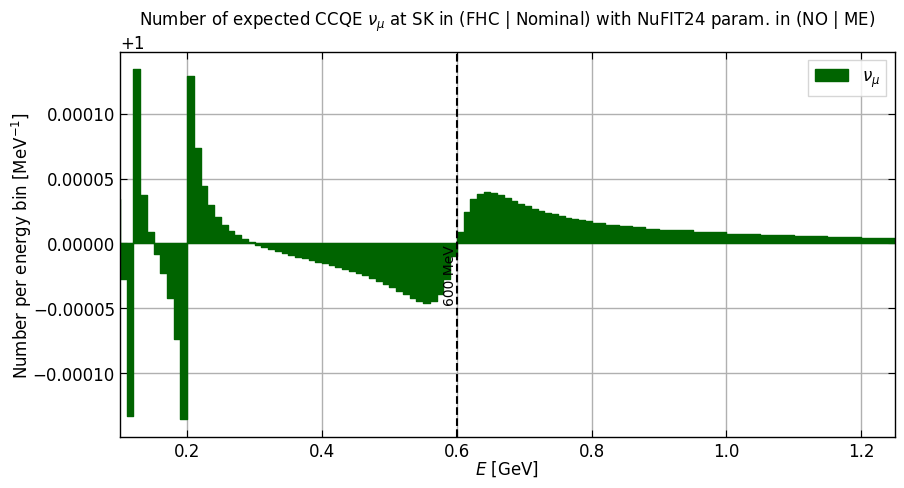

In [ ]:
for key in ["numu"]:
    plt.fill_between(
        sk_hist_bf.minE,
        sk_hist_fit[key] / sk_hist_bf[key],
        1,
        label=conv.print_dict[key],
        color=colors[key],
        step="post",
        # alpha=.5,
        # linestyle='--',
    )


plt.axvline(x=0.6, linestyle="--", color="black")
ax = plt.gca()
plt.text(sk_hist_fit[key] / sk_hist_bf[key]
plt.xlabel(r"$E$ [GeV]")
plt.ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
# plt.ylim(bottom=1e-1)
plt.xlim([0.1, 1.25])
plt.title(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
plt.legend()

plt.show()